## Lane detection system with duo-modular framework

Steps to run this code
- Change runtime > "GPU"
- upload "kaggle.json" which can be created as kaggle API token
- Run all

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d thomasfermi/lane-detection-for-carla-driving-simulator

100% 1.87G/1.88G [00:17<00:00, 42.7MB/s]
100% 1.88G/1.88G [00:17<00:00, 114MB/s] 


In [3]:
!unzip /content/lane-detection-for-carla-driving-simulator.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2318.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2319.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_232.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2320.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2321.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2322.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2323.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2324.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2325.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2326.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2327.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_2328.png  
  inflating: train/Town04_Clear_Noon_09_09_2020_14_57_22_frame

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

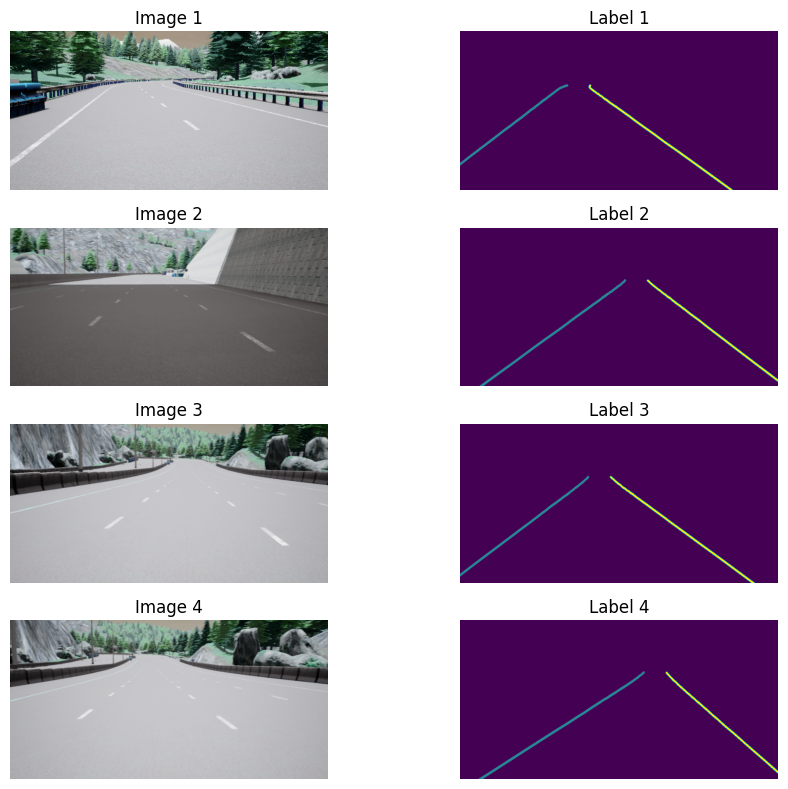

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Set directories
train_dir = '/content/train'
train_label_dir = '/content/train_label'
val_dir = '/content/val'
val_label_dir = '/content/val_label'

# Get filenames
train_files = sorted([f for f in os.listdir(train_dir) if f.endswith('.png')])
train_label_files = sorted([f for f in os.listdir(train_label_dir) if f.endswith('.png')])
val_files = sorted([f for f in os.listdir(val_dir) if f.endswith('.png')])
val_label_files = sorted([f for f in os.listdir(val_label_dir) if f.endswith('.png')])

# Number of samples to display
num_samples = 4

plt.figure(figsize=(10, num_samples * 2))

for i in range(num_samples):
    # Load image
    img = Image.open(os.path.join(train_dir, train_files[i]))
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(img)
    plt.title(f"Image {i+1}")
    plt.axis('off')

    # Load corresponding label
    label_img = Image.open(os.path.join(train_label_dir, train_label_files[i]))
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(label_img)
    plt.title(f"Label {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
import os
from PIL import Image
import numpy as np

# Get image paths
image_paths = [os.path.join(train_dir, img_name) for img_name in os.listdir(train_dir) if img_name.endswith('.png')]

# Initialize lists to store stats
widths, heights, aspect_ratios, mean_intensities = [], [], [], []

for img_path in image_paths:
    with Image.open(img_path) as img:
        # Image dimensions
        width, height = img.size
        widths.append(width)
        heights.append(height)
        aspect_ratios.append(width / height)

        # Pixel intensity
        img_array = np.array(img)
        mean_intensities.append(img_array.mean(axis=(0, 1)))  # Mean across width, height, for each channel

# Calculate descriptive statistics
avg_width = np.mean(widths)
avg_height = np.mean(heights)
avg_aspect_ratio = np.mean(aspect_ratios)
avg_intensity = np.mean(mean_intensities, axis=0)

print(f"Average Width: {avg_width}")
print(f"Average Height: {avg_height}")
print(f"Average Aspect Ratio: {avg_aspect_ratio}")
print(f"Average Color Intensity (RGB): {avg_intensity}")

Average Width: 1024.0
Average Height: 512.0
Average Aspect Ratio: 2.0
Average Color Intensity (RGB): [158.11548467 163.01958846 163.01909971]


In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split


class SegmentationDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, image_filenames, mask_filenames, batch_size, target_size, shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_filenames = [self.image_filenames[i] for i in batch_indexes]
        batch_mask_filenames = [self.mask_filenames[i] for i in batch_indexes]

        batch_images = np.empty((len(batch_indexes), *self.target_size, 3))
        batch_masks = np.empty((len(batch_indexes), *self.target_size, 1))

        for i, (image_filename, mask_filename) in enumerate(zip(batch_image_filenames, batch_mask_filenames)):
            image = load_img(os.path.join(self.image_dir, image_filename), target_size=self.target_size)
            mask = load_img(os.path.join(self.mask_dir, mask_filename), target_size=self.target_size, color_mode='grayscale')

            batch_images[i] = img_to_array(image) / 255.0
            batch_masks[i] = img_to_array(mask) / 255.0

        return batch_images, batch_masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Directories
train_image_dir = '/content/train'
train_mask_dir = '/content/train_label'
val_image_dir = '/content/val'
val_mask_dir = '/content/val_label'

# Get filenames
train_image_filenames = sorted(os.listdir(train_image_dir))
train_mask_filenames = sorted(os.listdir(train_mask_dir))
val_image_filenames = sorted(os.listdir(val_image_dir))
val_mask_filenames = sorted(os.listdir(val_mask_dir))

# Split train into train and test
train_image_filenames, test_image_filenames, train_mask_filenames, test_mask_filenames = train_test_split(
    train_image_filenames, train_mask_filenames, test_size=0.1, random_state=42)

# Create generators
train_generator = SegmentationDataGenerator(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    image_filenames=train_image_filenames,
    mask_filenames=train_mask_filenames,
    batch_size=16,
    target_size=(128, 128)
)

test_generator = SegmentationDataGenerator(
    image_dir=train_image_dir,
    mask_dir=train_mask_dir,
    image_filenames=test_image_filenames,
    mask_filenames=test_mask_filenames,
    batch_size=16,
    target_size=(128, 128),
    shuffle=False
)

val_generator = SegmentationDataGenerator(
    image_dir=val_image_dir,
    mask_dir=val_mask_dir,
    image_filenames=val_image_filenames,
    mask_filenames=val_mask_filenames,
    batch_size=16,
    target_size=(128, 128),
    shuffle=False
)

Visualizing and computing stats for Train data:


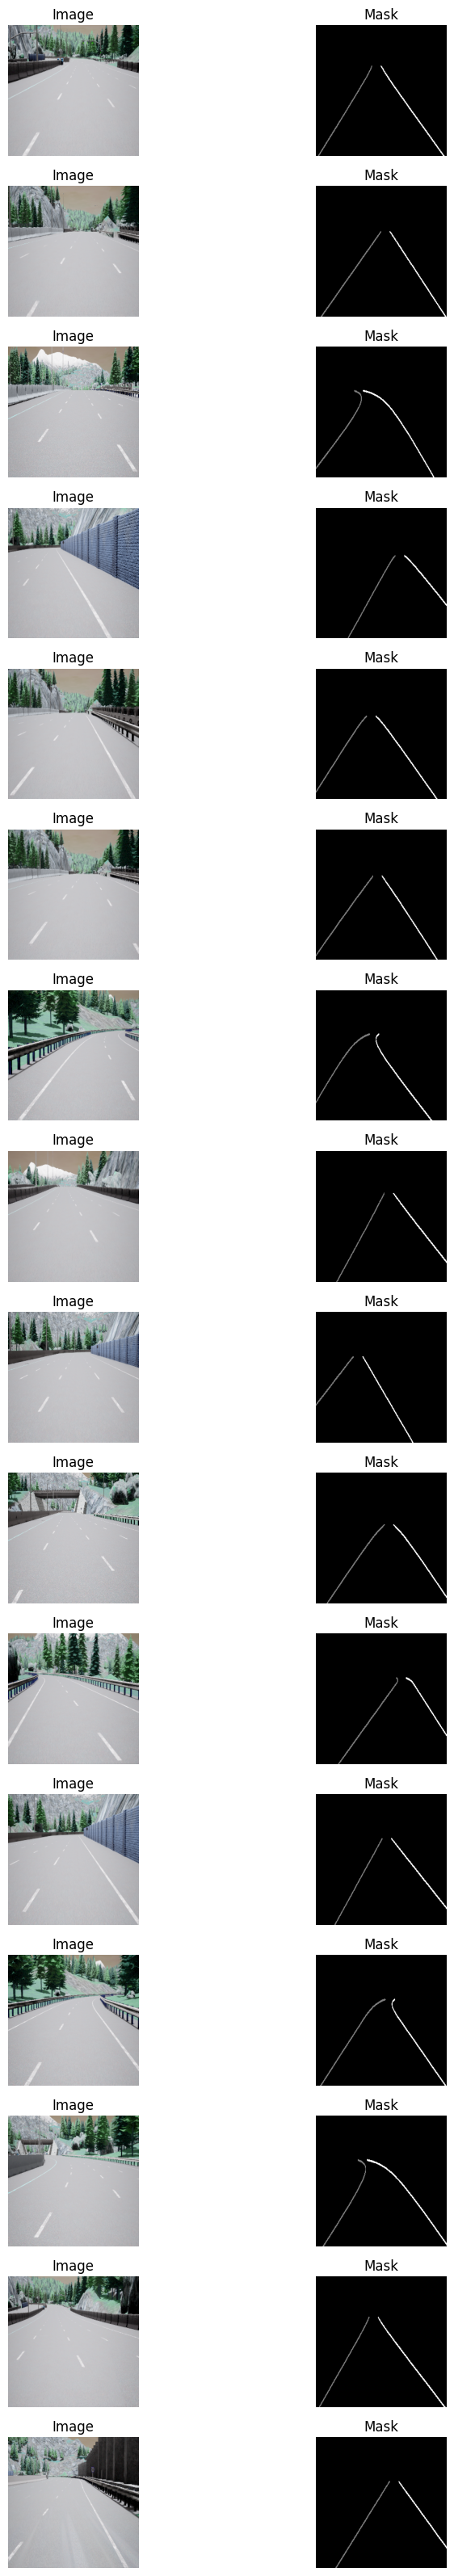

Number of images: 16
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Mean pixel value across the image batch: 0.6352
Standard deviation pixel value across the image batch: 0.2054
Mean pixel value across the mask batch: 0.0001
Standard deviation pixel value across the mask batch: 0.0007
Visualizing and computing stats for Test data:


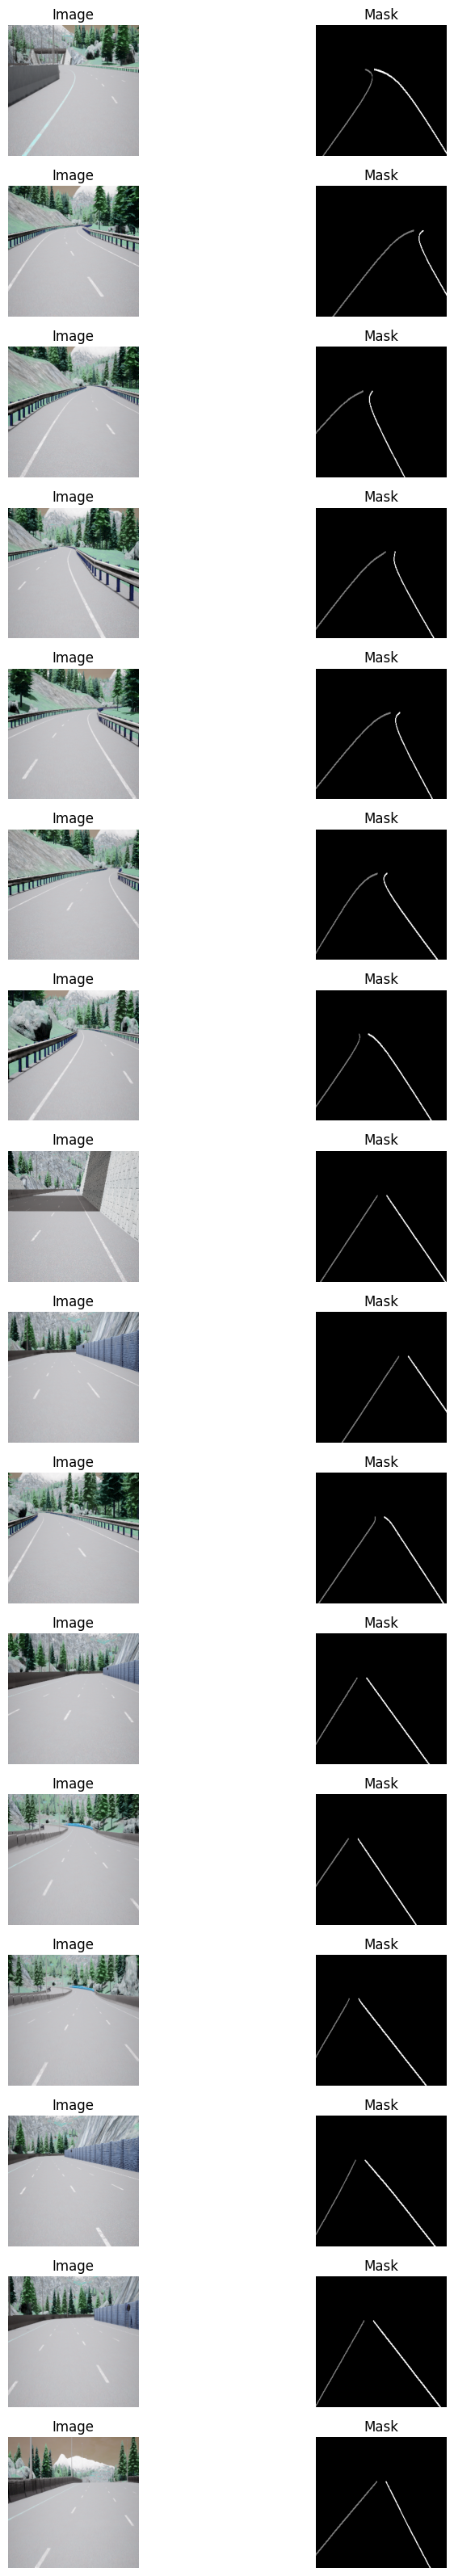

Number of images: 16
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Mean pixel value across the image batch: 0.6468
Standard deviation pixel value across the image batch: 0.1914
Mean pixel value across the mask batch: 0.0001
Standard deviation pixel value across the mask batch: 0.0007
Visualizing and computing stats for Validation data:


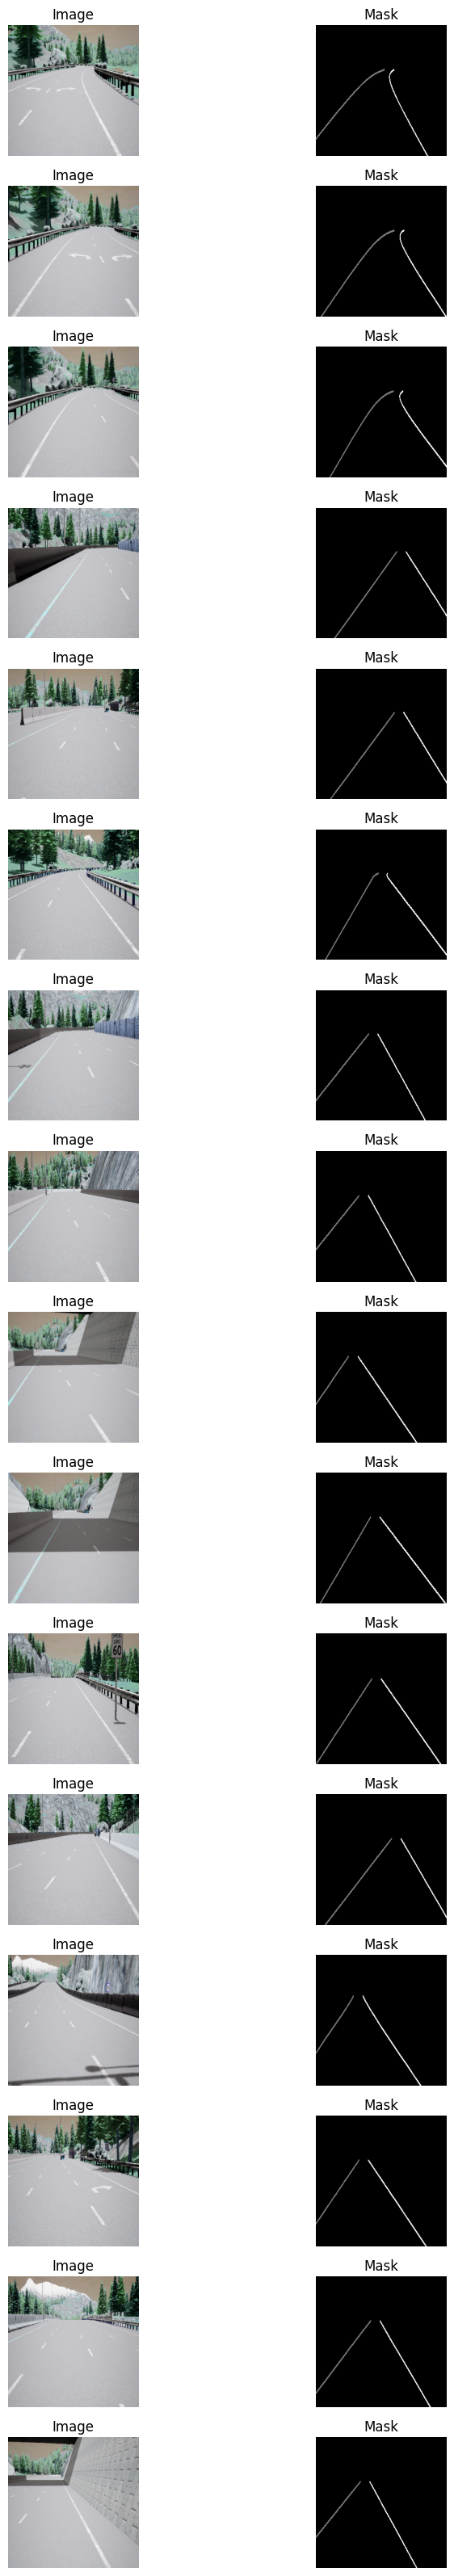

Number of images: 16
Image shape: (256, 256, 3)
Mask shape: (256, 256, 1)
Mean pixel value across the image batch: 0.6294
Standard deviation pixel value across the image batch: 0.2018
Mean pixel value across the mask batch: 0.0001
Standard deviation pixel value across the mask batch: 0.0007


In [16]:
import matplotlib.pyplot as plt

def visualize_batch(image_batch, mask_batch):
    """This function will visualize one batch of images and their corresponding masks."""
    batch_size = image_batch.shape[0]
    plt.figure(figsize=(10, 2 * batch_size))

    for i in range(batch_size):
        plt.subplot(batch_size, 2, 2*i + 1)
        plt.imshow(image_batch[i])
        plt.title('Image')
        plt.axis('off')

        plt.subplot(batch_size, 2, 2*i + 2)
        plt.imshow(mask_batch[i].squeeze(), cmap='gray')
        plt.title('Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def print_stats(image_batch, mask_batch):
    """This function prints out some basic statistics about the images and masks."""
    print(f"Number of images: {image_batch.shape[0]}")
    print(f"Image shape: {image_batch[0].shape}")
    print(f"Mask shape: {mask_batch[0].shape}")

    image_mean = np.mean(image_batch)
    image_std = np.std(image_batch)
    mask_mean = np.mean(mask_batch)
    mask_std = np.std(mask_batch)

    print(f"Mean pixel value across the image batch: {image_mean:.4f}")
    print(f"Standard deviation pixel value across the image batch: {image_std:.4f}")
    print(f"Mean pixel value across the mask batch: {mask_mean:.4f}")
    print(f"Standard deviation pixel value across the mask batch: {mask_std:.4f}")

# Now, let's use the generator to get a batch and then visualize and print stats
for generator, name in [(train_generator, 'Train'), (test_generator, 'Test'), (val_generator, 'Validation')]:
    print(f"Visualizing and computing stats for {name} data:")
    image_batch, mask_batch = generator.__getitem__(0)  # Get the first batch
    visualize_batch(image_batch, mask_batch)
    print_stats(image_batch, mask_batch)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanIoU
from sklearn.utils.class_weight import compute_class_weight

def build_unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    drop3 = Dropout(0.2)(conv3)
    pool3 = MaxPooling2D((2, 2))(drop3)

    # Decoder
    up4 = UpSampling2D((2, 2))(pool3)
    up4 = concatenate([up4, conv3], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up4)
    conv4 = BatchNormalization()(conv4)

    up5 = UpSampling2D((2, 2))(conv4)
    up5 = concatenate([up5, conv2], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    up6 = concatenate([up6, conv1], axis=-1)
    conv6 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = BatchNormalization()(conv6)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the model
input_shape = (128, 128, 3)
model = build_unet_model(input_shape)
optimizer = Adam(lr=0.0001)
from tensorflow.keras import backend as K

def weighted_binary_crossentropy(y_true, y_false, weight=1):
    # Calculate the binary crossentropy
    bce = K.binary_crossentropy(y_true, y_false)

    # Apply the weights
    weight_vector = y_true * weight + (1. - y_true)
    weighted_bce = weight_vector * bce

    return K.mean(weighted_bce)

# Calculate class weights (as an example, you might want to compute these values based on your dataset)
background_weight = 0.1  # Example weight for background
lane_weight = 1.0  # Example weight for lane

# Create a partial function to get a loss function with your weights
from functools import partial
custom_loss = partial(weighted_binary_crossentropy, weight=lane_weight)
custom_loss.__name__ ='weighted_bce'

# Compile the model with the custom loss
model.compile(optimizer=optimizer, loss=custom_loss, metrics=[tf.keras.metrics.BinaryAccuracy(), MeanIoU(num_classes=2)])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)
# Load the best model
model.load_weights('best_model.h5')
# Evaluate the model on the test set
# Adjusted evaluation to include a more comprehensive metric output
test_results = model.evaluate(test_generator)
test_loss, test_binary_accuracy, test_iou = test_results  # Update this line based on the metrics used
print(f"Test Loss: {test_loss}, Test Binary Accuracy: {test_binary_accuracy}, Test IoU: {test_iou}")

Epoch 1/20
173/173 [==============================] - ETA: 0s - loss: 0.4219 - binary_accuracy: 0.9365 - mean_io_u_1: 1.0000
Epoch 1: val_loss improved from inf to 0.17288, saving model to best_model.h5
173/173 [==============================] - 53s 283ms/step - loss: 0.4219 - binary_accuracy: 0.9365 - mean_io_u_1: 1.0000 - val_loss: 0.1729 - val_binary_accuracy: 0.9859 - val_mean_io_u_1: 1.0000 - lr: 0.0010
Epoch 2/20
173/173 [==============================] - ETA: 0s - loss: 0.0738 - binary_accuracy: 0.9859 - mean_io_u_1: 1.0000
Epoch 2: val_loss improved from 0.17288 to 0.03202, saving model to best_model.h5
173/173 [==============================] - 48s 275ms/step - loss: 0.0738 - binary_accuracy: 0.9859 - mean_io_u_1: 1.0000 - val_loss: 0.0320 - val_binary_accuracy: 0.9859 - val_mean_io_u_1: 1.0000 - lr: 0.0010
Epoch 3/20
173/173 [==============================] - ETA: 0s - loss: 0.0199 - binary_accuracy: 0.9859 - mean_io_u_1: 1.0000
Epoch 3: val_loss improved from 0.03202 to 0.01

In [10]:
#unet_model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 128, 128, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 128, 128, 32)         128       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)           0         ['batch_normalization_6[

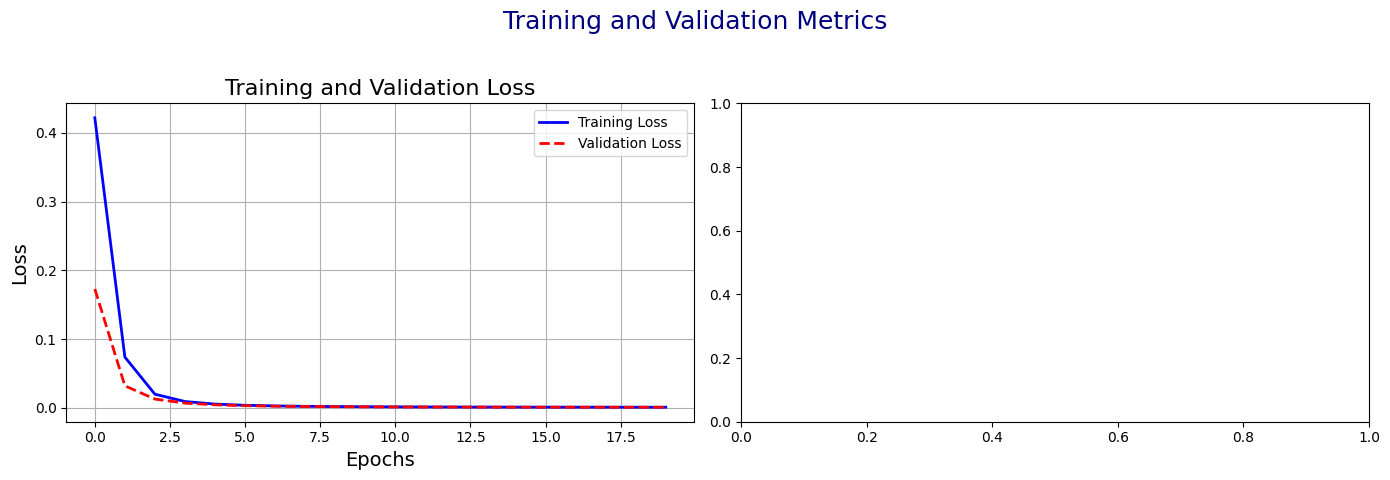

In [8]:
import matplotlib.pyplot as plt

# Extracting loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Setting up the figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotting training and validation loss
ax1.plot(train_loss, label='Training Loss', color='blue', linewidth=2)
ax1.plot(val_loss, label='Validation Loss', color='red', linestyle='--', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend()
ax1.grid(True)

# Customizing the overall aesthetics
plt.suptitle('Training and Validation Metrics', fontsize=18, color='navy')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to leave space for the suptitle
plt.show()

In [22]:
import gc
gc.collect()
tf.keras.backend.clear_session()

1/1 [==============================] - 0s 35ms/step


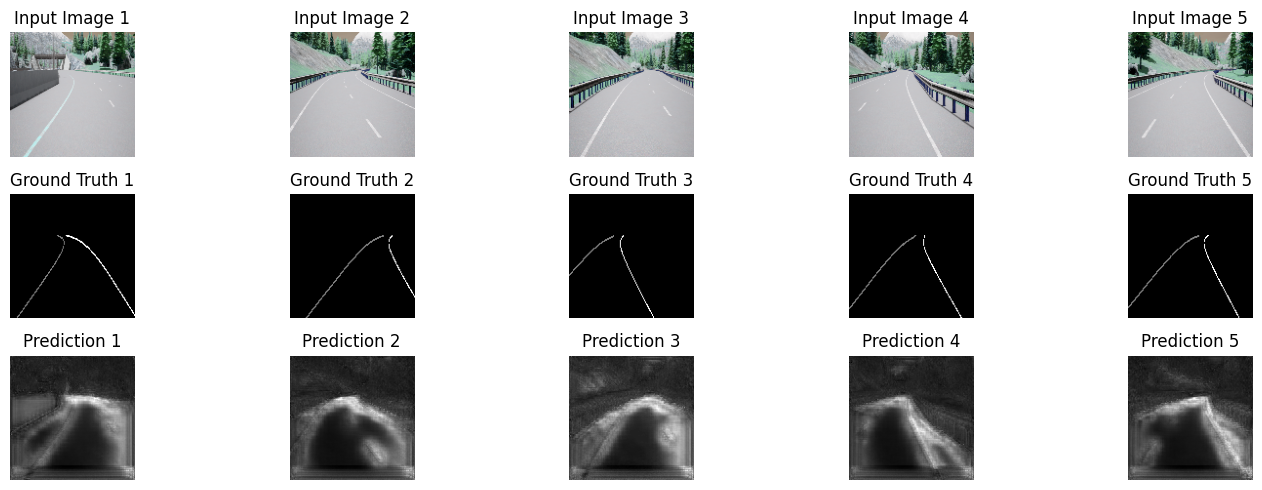

In [48]:
# Display some test images and predictions
import matplotlib.pyplot as plt
# Now, to visualize the predictions along with the images and masks, you can use:
num_samples = 5  # or set to len(test_images) to display the whole batch
plt.figure(figsize=(15, 5))
# Visualize predictions on test images
batch_index = 0
test_images, test_masks = test_generator.__getitem__(batch_index)
predictions = model.predict(test_images)
# Apply threshold to predictions
#predictions = (predictions > 0.000335).astype(np.float32)  # Apply a threshold of 0.001
for i in range(num_samples):
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(f'Input Image {i + 1}')

    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Ground Truth {i + 1}')

    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Prediction {i + 1}')

plt.tight_layout()
plt.show()

Epoch 1/20
173/173 [==============================] - ETA: 0s - loss: 0.0169 - binary_accuracy: 0.9849 - mean_io_u_5: 1.0000
Epoch 1: val_loss improved from inf to 0.00085, saving model to best_segnet_model.h5
173/173 [==============================] - 49s 272ms/step - loss: 0.0169 - binary_accuracy: 0.9849 - mean_io_u_5: 1.0000 - val_loss: 8.5353e-04 - val_binary_accuracy: 0.9859 - val_mean_io_u_5: 1.0000 - lr: 0.0010
Epoch 2/20
173/173 [==============================] - ETA: 0s - loss: 8.5693e-04 - binary_accuracy: 0.9859 - mean_io_u_5: 1.0000
Epoch 2: val_loss improved from 0.00085 to 0.00083, saving model to best_segnet_model.h5
173/173 [==============================] - 47s 272ms/step - loss: 8.5693e-04 - binary_accuracy: 0.9859 - mean_io_u_5: 1.0000 - val_loss: 8.3096e-04 - val_binary_accuracy: 0.9859 - val_mean_io_u_5: 1.0000 - lr: 0.0010
Epoch 3/20
173/173 [==============================] - ETA: 0s - loss: 8.4118e-04 - binary_accuracy: 0.9859 - mean_io_u_5: 1.0000
Epoch 3: val_

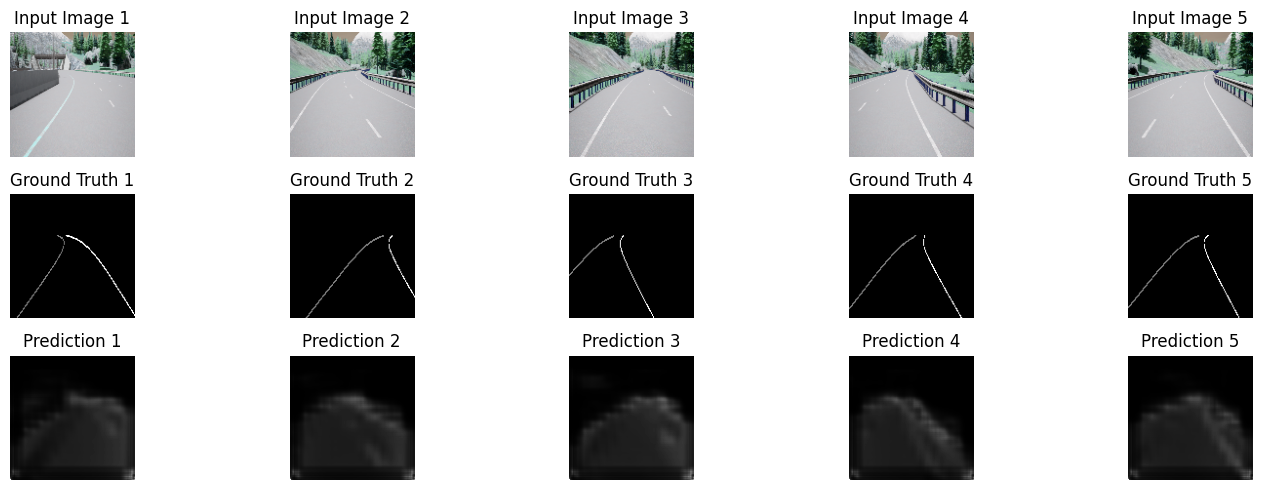

In [52]:
def build_segnet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Decoder
    up4 = UpSampling2D((2, 2))(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    up5 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    up6 = UpSampling2D((2, 2))(conv5)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(up6)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv6)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the SegNet model
segnet_model = build_segnet_model(input_shape)
segnet_model.compile(optimizer=Adam(lr=0.0001), loss=custom_loss, metrics=[tf.keras.metrics.BinaryAccuracy(), MeanIoU(num_classes=2)])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint('best_segnet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
epochs = 20
# Train the SegNet model
segnet_history = segnet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Load the best model
segnet_model.load_weights('best_segnet_model.h5')

# Evaluate the SegNet model on the test set
segnet_test_results = segnet_model.evaluate(test_generator)
segnet_test_loss, segnet_test_binary_accuracy, segnet_test_iou = segnet_test_results
print(f"SegNet Test Loss: {segnet_test_loss}, SegNet Test Binary Accuracy: {segnet_test_binary_accuracy}, SegNet Test IoU: {segnet_test_iou}")


# Display some test images and predictions
import matplotlib.pyplot as plt
# Now, to visualize the predictions along with the images and masks, you can use:
num_samples = 5  # or set to len(test_images) to display the whole batch
plt.figure(figsize=(15, 5))
# Visualize predictions on test images
batch_index = 0
test_images, test_masks = test_generator.__getitem__(batch_index)
predictions = segnet_model.predict(test_images)
# Apply threshold to predictions
threshold = 0.004
#predictions[predictions < threshold] = 0
for i in range(num_samples):
    plt.subplot(3, num_samples, i + 1)
    plt.imshow(test_images[i])
    plt.axis('off')
    plt.title(f'Input Image {i + 1}')

    plt.subplot(3, num_samples, num_samples + i + 1)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Ground Truth {i + 1}')

    plt.subplot(3, num_samples, 2 * num_samples + i + 1)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f'Prediction {i + 1}')

plt.tight_layout()
plt.show()

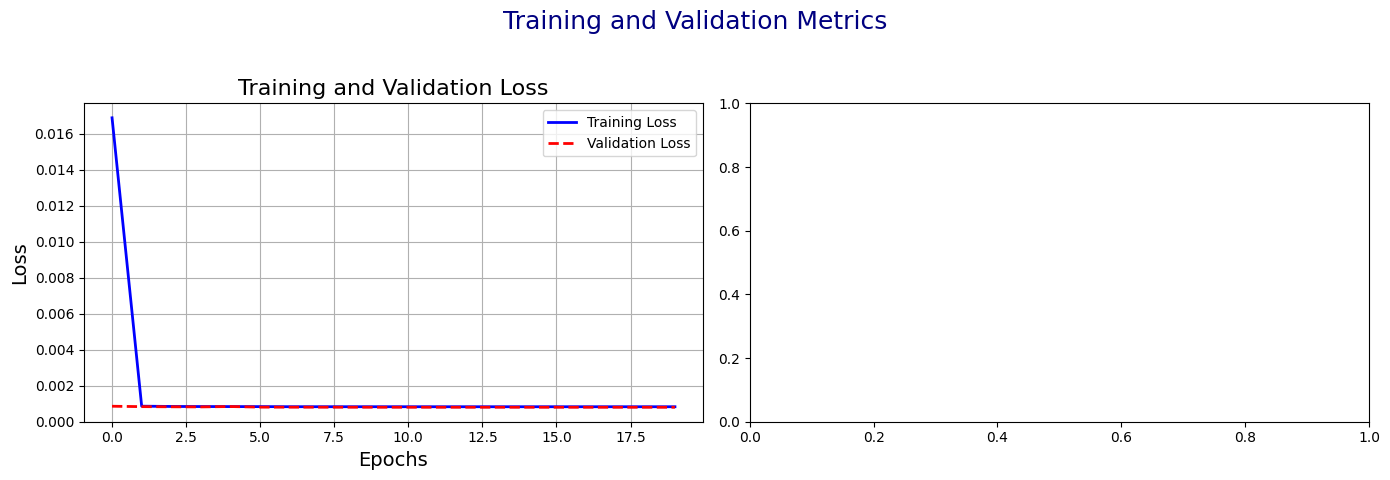

In [53]:
# Extracting loss and accuracy from the history object
train_loss = segnet_history.history['loss']
val_loss = segnet_history.history['val_loss']

# Setting up the figure and axes for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plotting training and validation loss
ax1.plot(train_loss, label='Training Loss', color='blue', linewidth=2)
ax1.plot(val_loss, label='Validation Loss', color='red', linestyle='--', linewidth=2)
ax1.set_title('Training and Validation Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.legend()
ax1.grid(True)

# Customizing the overall aesthetics
plt.suptitle('Training and Validation Metrics', fontsize=18, color='navy')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect to leave space for the suptitle
plt.show()

In [ ]:
segnet_model.summary()

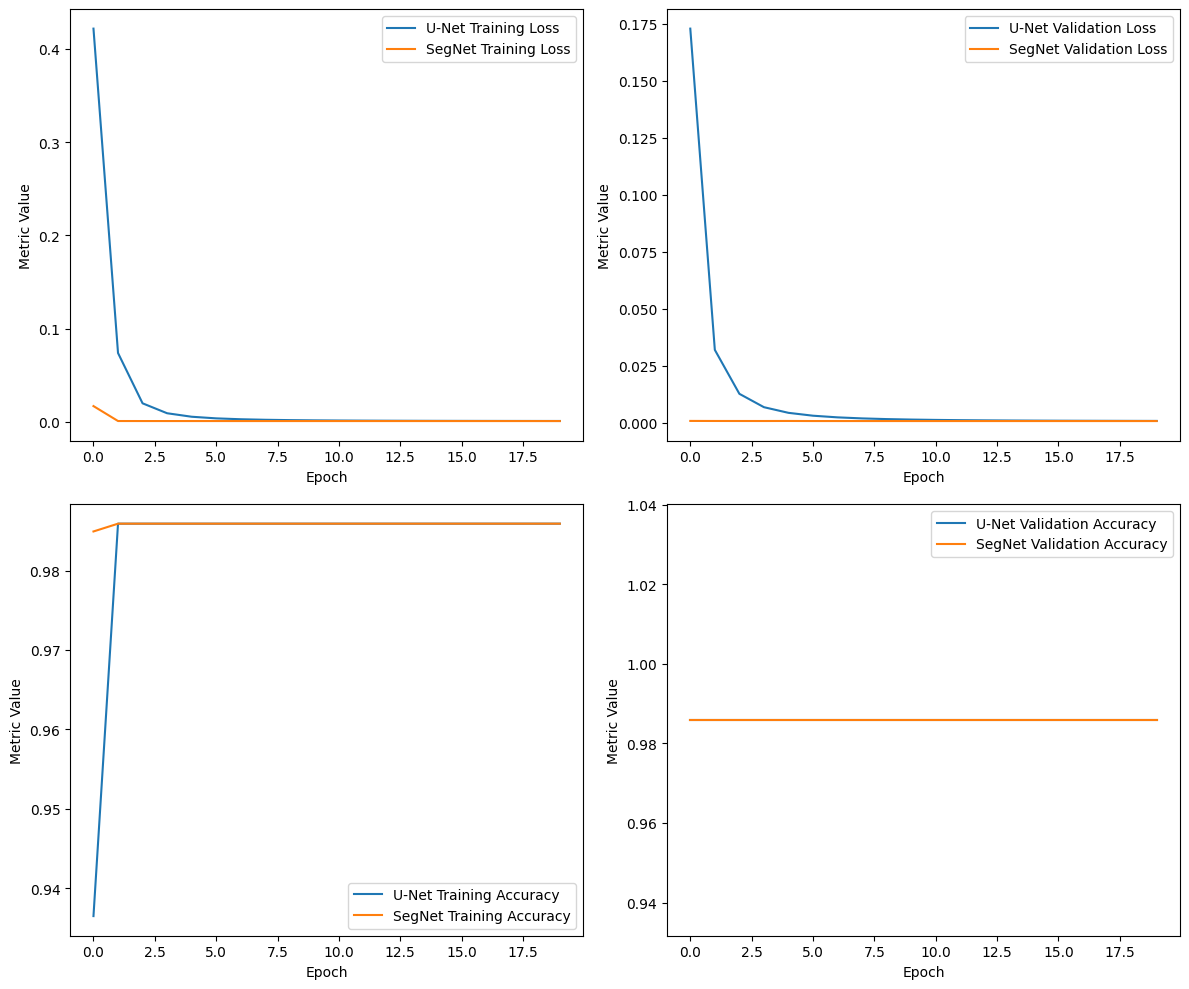

Model  Test Loss  Test Accuracy
0   U-Net   0.000835       0.985919
1  SegNet   0.000828       0.985919

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Extract training history for comparison
unet_metrics = pd.DataFrame({
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss'],
    'Training Accuracy': history.history['binary_accuracy'],
    'Validation Accuracy': history.history['val_binary_accuracy']
})

segnet_metrics = pd.DataFrame({
    'Training Loss': segnet_history.history['loss'],
    'Validation Loss': segnet_history.history['val_loss'],
    'Training Accuracy': segnet_history.history['binary_accuracy'],
    'Validation Accuracy': segnet_history.history['val_binary_accuracy']
})

# Step 2: Create a summary table for final test metrics
summary_table = pd.DataFrame({
    'Model': ['U-Net', 'SegNet'],
    'Test Loss': [test_loss, segnet_test_loss],
    'Test Accuracy': [test_binary_accuracy, segnet_test_binary_accuracy]
})

# Step 3: Plot training progress
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].plot(unet_metrics['Training Loss'], label='U-Net Training Loss')
axs[0, 0].plot(segnet_metrics['Training Loss'], label='SegNet Training Loss')
axs[0, 1].plot(unet_metrics['Validation Loss'], label='U-Net Validation Loss')
axs[0, 1].plot(segnet_metrics['Validation Loss'], label='SegNet Validation Loss')

axs[1, 0].plot(unet_metrics['Training Accuracy'], label='U-Net Training Accuracy')
axs[1, 0].plot(segnet_metrics['Training Accuracy'], label='SegNet Training Accuracy')
axs[1, 1].plot(unet_metrics['Validation Accuracy'], label='U-Net Validation Accuracy')
axs[1, 1].plot(segnet_metrics['Validation Accuracy'], label='SegNet Validation Accuracy')

for ax in axs.flat:
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')

plt.tight_layout()
plt.show()

# Display the summary table
summary_table

U-Net Total Parameters: 528449
SegNet Total Parameters: 333121
1/1 [==============================] - 0s 18ms/step
U-Net Average Inference Time: 0.3657 seconds
SegNet Average Inference Time: 0.2996 seconds
1/1 [==============================] - 0s 26ms/step
U-Net Confusion Matrix:
[[5046272]]
1/1 [==============================] - 0s 21ms/step
SegNet Confusion Matrix:
[[5046272]]


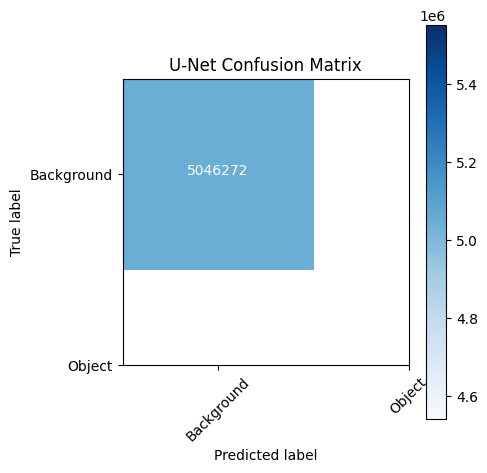

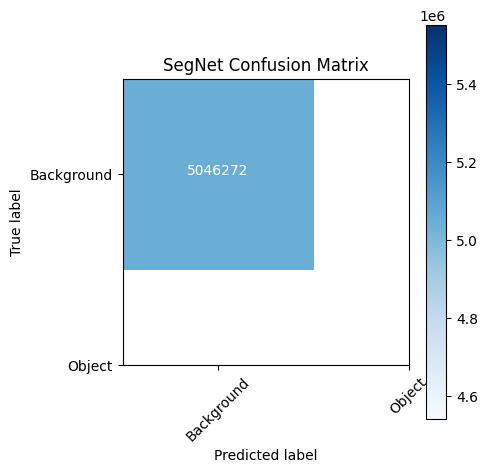

In [58]:
import time
import numpy as np
from sklearn.model_selection import KFold

# Calculate model complexities
unet_params = model.count_params()
segnet_params = segnet_model.count_params()
print(f"U-Net Total Parameters: {unet_params}")
print(f"SegNet Total Parameters: {segnet_params}")

# Measure inference time
def measure_inference_time(model, generator, num_samples=100):
    start_time = time.time()
    for _ in range(num_samples):
        img, _ = generator.__getitem__(np.random.randint(0, len(generator)))
        model.predict(np.expand_dims(img[0], axis=0))
    average_time = (time.time() - start_time) / num_samples
    return average_time

unet_inference_time = measure_inference_time(model, test_generator)
segnet_inference_time = measure_inference_time(segnet_model, test_generator)
print(f"U-Net Average Inference Time: {unet_inference_time:.4f} seconds")
print(f"SegNet Average Inference Time: {segnet_inference_time:.4f} seconds")


from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model_and_generate_confusion_matrix(model, generator):
    # Initialize accumulators
    all_predictions = []
    all_true_labels = []

    # Iterate over all batches in the generator
    for i in range(len(generator)):
        images, true_masks = generator[i]
        # Get model predictions
        predictions = model.predict(images)
        # Threshold predictions to get binary values
        predictions = (predictions > 0.5).astype(np.uint8)
        true_masks = (true_masks > 0.5).astype(np.uint8)

        # Flatten to 1D array
        predictions = predictions.flatten()
        true_masks = true_masks.flatten()

        # Accumulate results
        all_predictions.extend(predictions)
        all_true_labels.extend(true_masks)

    # Calculate confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)

    return cm

# Evaluate U-Net model and generate confusion matrix
unet_confusion_matrix = evaluate_model_and_generate_confusion_matrix(model, test_generator)
print("U-Net Confusion Matrix:")
print(unet_confusion_matrix)

# Evaluate SegNet model and generate confusion matrix
segnet_confusion_matrix = evaluate_model_and_generate_confusion_matrix(segnet_model, test_generator)
print("SegNet Confusion Matrix:")
print(segnet_confusion_matrix)

# Optionally, visualize the confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Background', 'Object'], rotation=45)
    plt.yticks(tick_marks, ['Background', 'Object'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.grid(False)

    # Labeling the values
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

plot_confusion_matrix(unet_confusion_matrix, title='U-Net Confusion Matrix')
plot_confusion_matrix(segnet_confusion_matrix, title='SegNet Confusion Matrix')

In [62]:
def dice_coefficient(true_mask, pred_mask):
    true_flat = true_mask.flatten()
    pred_flat = pred_mask.flatten()
    intersection = np.sum(true_flat * pred_flat)
    return (2. * intersection) / (np.sum(true_flat) + np.sum(pred_flat))

# Accumulate Dice scores for each model
unet_dice_scores = []
segnet_dice_scores = []

for i in range(len(test_generator)):
    images, true_masks = test_generator[i]
    unet_pred_masks = model.predict(images, verbose = 0)
    segnet_pred_masks = segnet_model.predict(images, verbose = 0)

    unet_dice = dice_coefficient(true_masks, unet_pred_masks)
    segnet_dice = dice_coefficient(true_masks, segnet_pred_masks)

    unet_dice_scores.append(unet_dice)
    segnet_dice_scores.append(segnet_dice)

# Calculate average Dice scores
unet_avg_dice = np.mean(unet_dice_scores)
segnet_avg_dice = np.mean(segnet_dice_scores)

print(f"Average Dice Coefficient for U-Net: {unet_avg_dice}")
print(f"Average Dice Coefficient for SegNet: {segnet_avg_dice}")

Average Dice Coefficient for U-Net: 0.0001511572480695077
Average Dice Coefficient for SegNet: 0.00014566329904877324


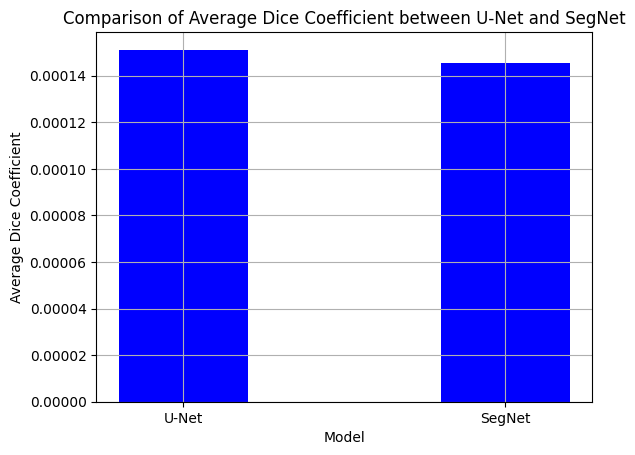

In [65]:
import matplotlib.pyplot as plt

# Prepare data
models = ['U-Net', 'SegNet']
dice_scores = [unet_avg_dice, segnet_avg_dice]

# Create bar chart
plt.bar(models, dice_scores, color='blue', width=0.4)

# Add labels and title
plt.xlabel("Model")
plt.ylabel("Average Dice Coefficient")
plt.title("Comparison of Average Dice Coefficient between U-Net and SegNet")

# Add grid and show plot
plt.grid(True)
plt.show()